In [20]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

# 数据读取和预处理
train = pd.read_csv('E:/b/train.csv')
test = pd.read_csv('E:/b/test.csv')

# 将训练数据划分为训练集和验证集
train_df, val_df = train_test_split(train, test_size=0.2, random_state=42)

print("训练数据集形状:", train_df.shape)
print("验证数据集形状:", val_df.shape)
print("测试数据集形状:", test.shape)


训练数据集形状: (48000, 785)
验证数据集形状: (12000, 785)
测试数据集形状: (5000, 785)


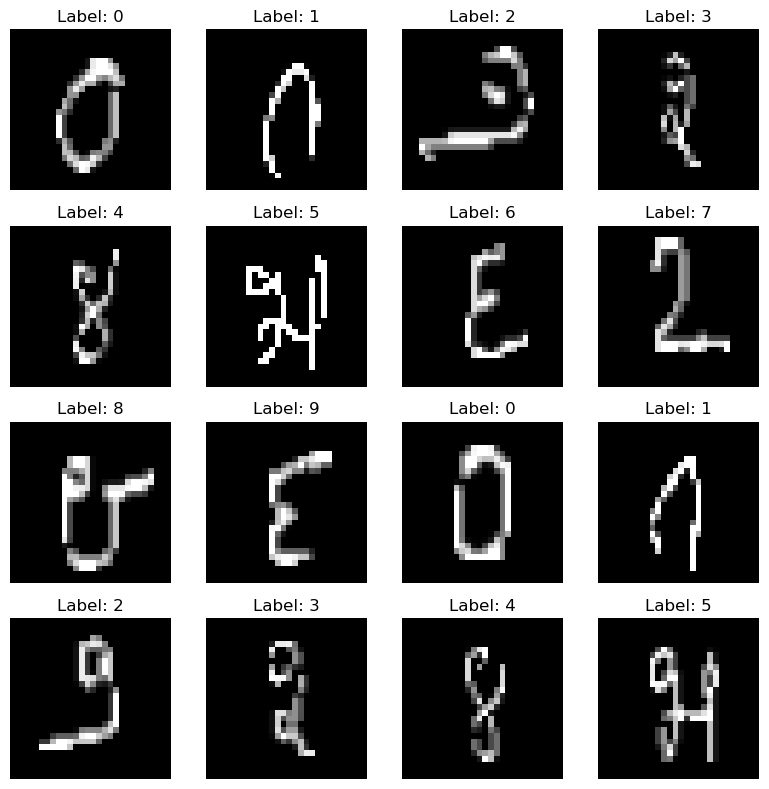

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

train = pd.read_csv('E:/b/train.csv')

# 从DataFrame中提取图像像素和标签
images = train.iloc[:, 1:].values  
labels = train.iloc[:, 0].values   

# 将图像从平铺的数组转换成28x28的矩阵
images = images.reshape(-1, 28, 28)

# 绘制前16张图像
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)  # (4 rows, 4 columns)
    plt.imshow(images[i], cmap='gray')  # 显示灰度图像
    plt.title(f'Label: {labels[i]}')  # 设置标题显示标签
    plt.axis('off')  
plt.tight_layout()
plt.show()


In [6]:
class KannadaMNISTDataset(Dataset):
    def __init__(self, dataframe, transform=None, is_test=False):
        self.data = dataframe
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = np.array(self.data.iloc[idx, 1:], dtype=np.uint8).reshape((28, 28, 1))
        if self.transform:
            image = self.transform(image)
        if self.is_test:
            return image
        label = self.data.iloc[idx, 0]
        return image, label

# 数据加载器
def get_data_loaders(train_df, val_df, test_df, batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    train_dataset = KannadaMNISTDataset(train_df, transform=transform)
    val_dataset = KannadaMNISTDataset(val_df, transform=transform)
    test_dataset = KannadaMNISTDataset(test_df, transform=transform, is_test=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader

batch_size = 64
train_loader, val_loader, test_loader = get_data_loaders(train_df, val_df, test, batch_size)


In [7]:
# LeNet模型定义
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = LeNet()

In [8]:
# 训练函数
def Ktrain(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    model.train()
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        running_train_loss = 0.0
        running_val_loss = 0.0
        
        # 训练阶段
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        
        # 验证阶段
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
        
        model.train()
        
        average_train_loss = running_train_loss / len(train_loader)
        average_val_loss = running_val_loss / len(val_loader)
        train_losses.append(average_train_loss)
        val_losses.append(average_val_loss)
        print(f"Epoch {epoch + 1}, Train Loss: {average_train_loss}, Val Loss: {average_val_loss}")
    
    return train_losses, val_losses

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_epochs = 50

train_losses, val_losses = Ktrain(model, criterion, optimizer, train_loader, val_loader, num_epochs)


Epoch 1, Train Loss: 2.264462838490804, Val Loss: 2.088975178434494
Epoch 2, Train Loss: 0.7605765185554823, Val Loss: 0.21542771489537776
Epoch 3, Train Loss: 0.1746853196124236, Val Loss: 0.1319429423719486
Epoch 4, Train Loss: 0.12382243500153224, Val Loss: 0.10813638569906037
Epoch 5, Train Loss: 0.09838866753689944, Val Loss: 0.08452741963234037
Epoch 6, Train Loss: 0.08260639352165162, Val Loss: 0.07645016559399664
Epoch 7, Train Loss: 0.0713139656924953, Val Loss: 0.0670116419081596
Epoch 8, Train Loss: 0.06315232065195839, Val Loss: 0.05878390856037669
Epoch 9, Train Loss: 0.05614686226161818, Val Loss: 0.05380136359661342
Epoch 10, Train Loss: 0.05062336650149276, Val Loss: 0.053302054580776616
Epoch 11, Train Loss: 0.04774242314323783, Val Loss: 0.04899662622359601
Epoch 12, Train Loss: 0.04393589511156703, Val Loss: 0.0454755799369292
Epoch 13, Train Loss: 0.04077344767004251, Val Loss: 0.049567965929337
Epoch 14, Train Loss: 0.03899700867819289, Val Loss: 0.0414292861291385

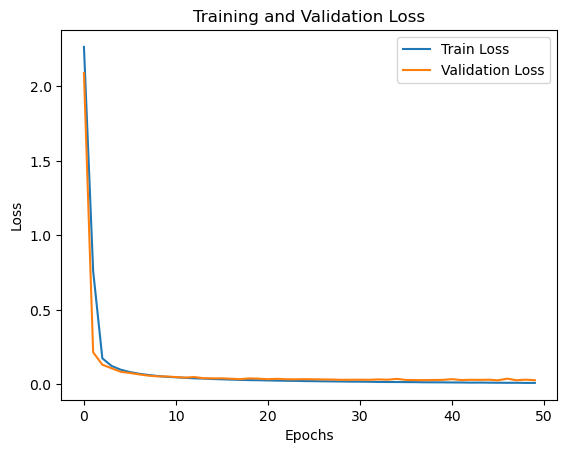

Accuracy: 0.9919166666666667, Precision: 0.991945823638053, Recall: 0.9919166666666667, F1 Score: 0.9919179253494639
Confusion Matrix:
[[1157   16    0    0    0    0    0    1    2    1]
 [   0 1215    0    2    0    0    0    0    0    1]
 [   1    0 1223    0    0    0    0    0    0    0]
 [   0    0    0 1166    2    4    1   11    0    0]
 [   1    0    0    2 1210    6    0    0    2    0]
 [   0    1    1    3    3 1179    0    1    0    0]
 [   0    0    0    1    0    0 1161    6    0    1]
 [   0    0    0    2    0    0   11 1206    0    0]
 [   2    1    1    0    0    0    0    0 1182    0]
 [   1    0    0    0    0    0    7    1    1 1204]]


In [9]:
# 可视化训练和验证损失
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

plot_losses(train_losses, val_losses)

# 模型评估
def evaluate_model(model, val_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)
    return accuracy, precision, recall, f1, cm

accuracy, precision, recall, f1, cm = evaluate_model(model, val_loader)
print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")
print("Confusion Matrix:")
print(cm)


In [31]:
# 生成提交文件
def generate_submission_file(model, test_loader, filename="E:/b/submission.csv"):
    model.eval()
    results = []
    with torch.no_grad():
        for images in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            results.extend(predicted.numpy())
    submission_df = pd.DataFrame({"id": np.arange(len(results)), "label": results})
    submission_df.to_csv(filename, index=False)

generate_submission_file(model, test_loader)

# 检查生成的提交文件
submission = pd.read_csv("E:/b/submission.csv")
print(submission.head())
print("提交文件行数:", len(submission))
print("测试数据集行数:", len(test))

# 确认提交文件行数与测试数据集行数相同
assert len(submission) == len(test), "提交文件的行数应与测试数据集的行数相同"


   id  label
0   0      3
1   1      0
2   2      2
3   3      6
4   4      7
提交文件行数: 5000
测试数据集行数: 5000


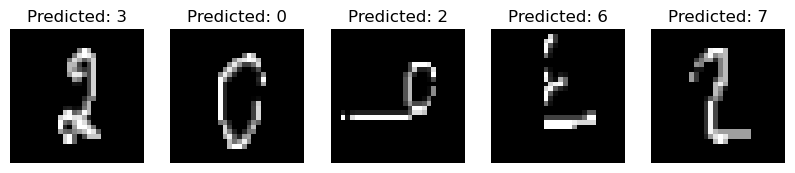

In [33]:
import matplotlib.pyplot as plt
import torch

# 图像可视化
def visualize_predictions(model, test_loader, num_samples=5):
    model.eval()
    plt.figure(figsize=(10, 5))
    with torch.no_grad():
        # 获取一个批次的图像
        images = next(iter(test_loader))
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        # 显示前 num_samples 个图像及其预测结果
        for i in range(num_samples):
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(images[i][0].cpu().numpy(), cmap='gray')
            plt.title(f"Predicted: {predicted[i].item()}")
            plt.axis('off')
    plt.show()

# 运行这个函数来可视化预测结果
visualize_predictions(model, test_loader)


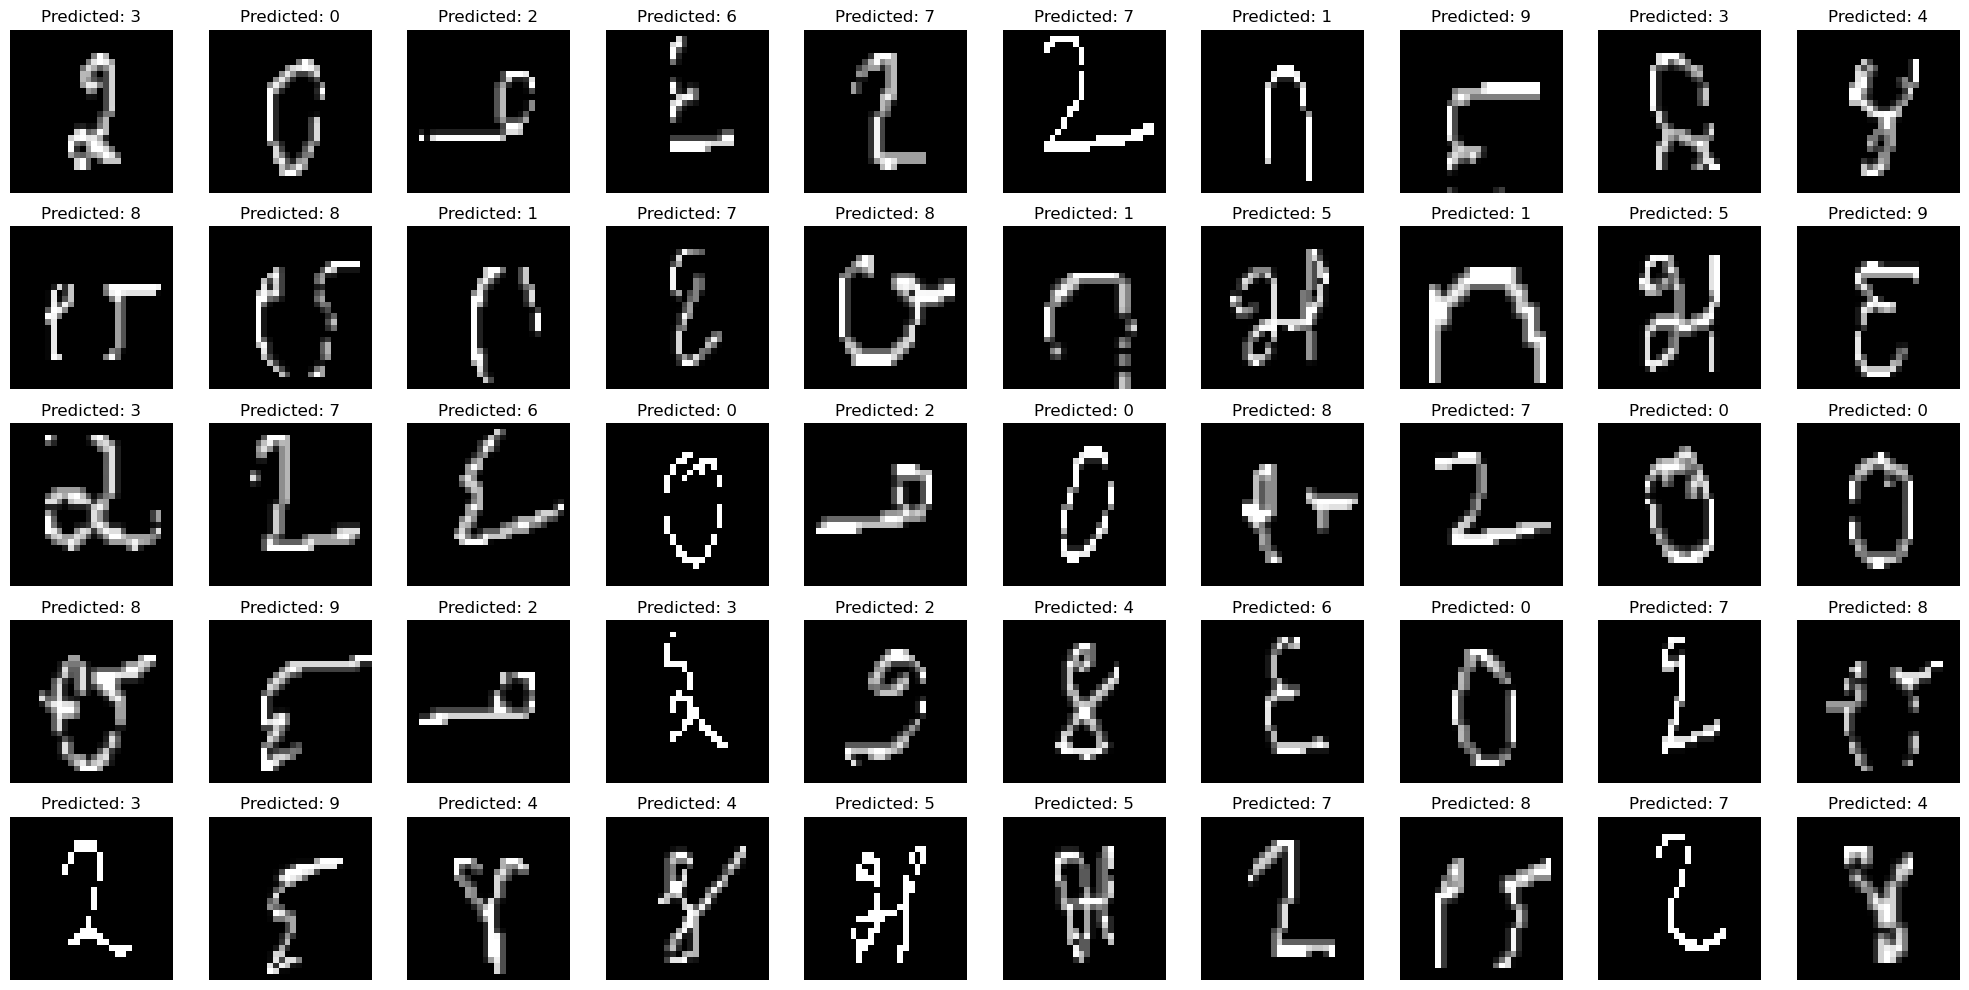

In [34]:
import matplotlib.pyplot as plt
import torch

# 图像可视化
def visualize_predictions(model, test_loader, num_samples=50, images_per_row=10):
    model.eval()
    plt.figure(figsize=(20, 10))
    with torch.no_grad():
        # 获取测试集前 num_samples 张图像
        images = []
        labels = []
        count = 0
        for img_batch in test_loader:
            images.append(img_batch)
            count += img_batch.size(0)
            if count >= num_samples:
                break
        images = torch.cat(images)[:num_samples]  # 合并所有批次并限制数量
        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        # 显示前 num_samples 个图像及其预测结果
        rows = (num_samples + images_per_row - 1) // images_per_row  # 计算需要的行数
        for i in range(num_samples):
            plt.subplot(rows, images_per_row, i + 1)
            plt.imshow(images[i][0].cpu().numpy(), cmap='gray')
            plt.title(f"Predicted: {predicted[i].item()}")
            plt.axis('off')
    plt.tight_layout()
    plt.show()

# 运行这个函数来可视化预测结果
visualize_predictions(model, test_loader)
